# VolcanoLoader
This notebook loads in the Petlab dataset of volcanic rock samples and links each sample to geo-tectonic time-dependent (and also cumultaive spatio-dependent) grids.

The second part of the notebook also generates a series of psuedo-random samples to use a benchmark for Machine Learning methods.

For every point in the petlab dataset (volcanic rock samples) we need to determine the:
 - age of its formation.
 - reconstructed position of its formation at that age.
 - values of various time-dependent geophysical grids at each reconstructed formation position.
 
## Inputs
**Volcanic Samples**
* Petlab_Jun2019_v8_Horomaka_edit.xlsx

**Plate Polygon/Rotation Files**
* input_directory = "../Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"
* static_polygons_filename = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
* rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))

**Geo Grids**
* agegrid_filename = "../Data/M2020_AgeGrids/Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"
* carcrust_filename = "../Data/Crust/carbon_crust_grid_{:.0f}.nc"
* subcarcrust_filename = "../Data/Crust/subducted_carbon_crust_{:.0f}.nc"
* carlith_filename = "../Data/Lithosphere/carbon_lithosphere_grid_{:.0f}.nc"
* subcarlith_filename = "../Data/Lithosphere/subducted_carbon_lithosphere_{:.0f}.nc"
* carsed_filename = "../Data/Sediment/carbon_sediment_grid_{:.0f}.nc"
* subcarsed_filename ="../Data/Sediment/subducted_carbon_sediment_{:.0f}.nc"
* carserp_filename = "../Data/Serpentinite/carbon_serpentinite_grid_{:.0f}.nc"
* subcarserp_filename = "../Data/Serpentinite/subducted_carbon_serpentinite_{:.0f}.nc"

* slabtop_filename = "../Data/slab_tops.nc" #Think about how this gets coregistered to each point's birth position
* slabage_filename = "../Data/cumulative_slab_age_grid.nc" 
* slabdip_filename = "../Data/cumulative_slab_dip_grid.nc"
* slabthick_filename = "../Data/cumulative_slab_thickness_grid.nc"
* slabvel_filename = "../Data/cumulative_slab_vel_grid.nc"
* slabsubage_filename = "../Data/cumulative_subduction_age.nc"
 
## Outputs 

**Lat/Lon/PlateID** for input into GPlates
* reconpoints.csv

**Updated Volcanic Samples**

*Equivalent to Volcanic Sample input data but with addended tectonic grid reconstructed values with each lat lon point reconstrcuted*

* petlab_withgrids.csv

*Same data with randomised distribution of ages*
* petlab_withgrids_neg_age.csv

*Same data but with randomised distribution of present day lat/lons (and thereby arbritray reconstructed positons)*
* petlab_withgrids_neg_loc.csv

In [5]:
#Load in required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
import glob
import os

#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates
import ptt

In [6]:
df=pd.read_excel("Petlab_Jun2019_v8_Horomaka_edit.xlsx",engine='openpyxl')
#print(df.columns.values)
df

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,age_model_assumed_Ma,Sr87_86i_calc,Nd143_144i_calc,eNdi_calc,Hf176_177i_calc,eHfi_calc,Pb206_204i_calc,Pb207_204i_calc,Pb208_204i_calc,Petlab notes
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,63156,other,TAS-65828,Tasmantid,Dredge,Franklin 3/85-DHUnspec,1150,1250,TAS-65828,31206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1454,63157,other,TAS-65835,Tasmantid,Dredge,Franklin 3/85-DHUnspec,1150,1250,TAS-65835,31206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1455,63158,other,TAS-65836,Tasmantid,Dredge,Franklin 3/85-DHUnspec,1150,1250,TAS-65836,31206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,63172,other,TAS-65839,Tasmantid,Dredge,Franklin 3/85-T5,1100,1400,TAS-65839,31206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Start by setting/determingin a numerical age for every sample

#Few ways to do this. Maybe an average of all geological max/mins?
#Max geological age might be beginning of eruptions? So set that for now
#and use if their is no analytical age associated with the sample.

#function for numerical timescale conversion
ts=Timescale()

df['Age_Num']=df.apply(lambda row: ts.text2age(row['Age_Max'])[0], axis=1)

#Function to clean up a numerical age
def ager(x):
    #First, if it has an analytical age, use that
    if ~pd.isnull(x['age_sample_result_Ma']): return x['age_sample_result_Ma']
    #Otherwise use the numerical age set before from the geological age
    elif ~pd.isnull(x['Age_Num']): return x['Age_Num']
    #Otherwise set to nan
    else: return np.nan
    
df['Age']= df.apply(ager, axis=1)

In [9]:
#We can deop unnecessary columns for clarity. Or just keep them for now, and drop them later if required
# df.drop(columns=['Collection','Coll_No', 'Feature_Type',
#  'Feature_Name', 'Top_Depth', 'Bottom_Depth', 'Field_Number',
#  'Collection_Date', 'Date_Rounding', 'Collectors', 'Country_Name',
#  'NZMG_Sheet', 'NZMG_East', 'NZMG_North', 'Method',
#  'Accuracy', 'Site_Description', 'In_Situ', 'Rock_Description', 'Colour',
#  'Sample_Types', 'Lab_Sample_ID(s)', 'Material(s)', 'Part_Analysed',
#  'Analysis_ID(s)', 'Investigator(s)', 'Analysis_Method(s)',
#  'Geochron_Method(s)', 'Laboratory(s)', 'Lab_Number(s)', 'Analysis_Date(s)',
#  'Analysis_Date_Rounding(s)', 'Analysis_Publication(s)',
#  'Analysis_Bib_Ref(s)','Analysis_Comment(s)','Petlab notes'],inplace=True)

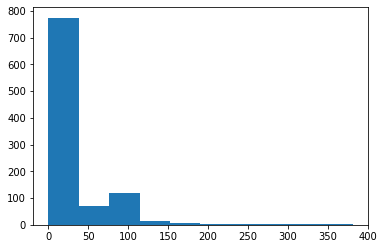

There is clearly a bias of data toward younger times.
This will have implications for how we analyse the data and try to find correlations.
dict_keys(['Cambrian', 'Carboniferous', 'Cretaceous', 'Devonian', 'Eocene', 'Jurassic', 'Miocene', 'Oligocene', 'Paleocene', 'Permian', 'Pliocene', 'Precambrian', 'Quaternary', 'Triassic'])
Cambrian (541.0, 485.4)


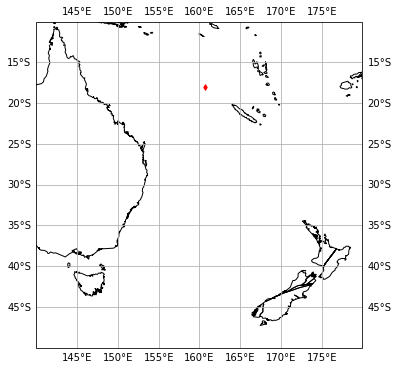

Carboniferous (358.9, 298.9)


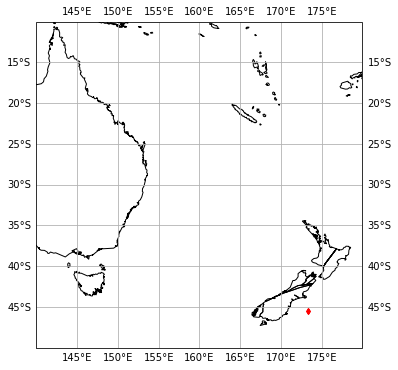

Cretaceous (145.0, 66.0)


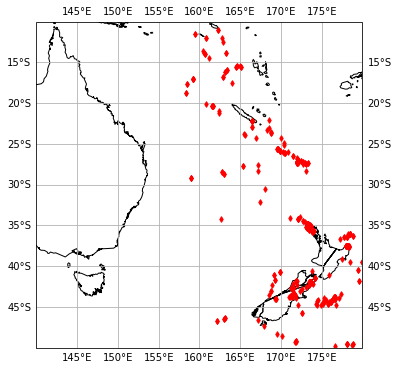

Devonian (419.2, 358.9)


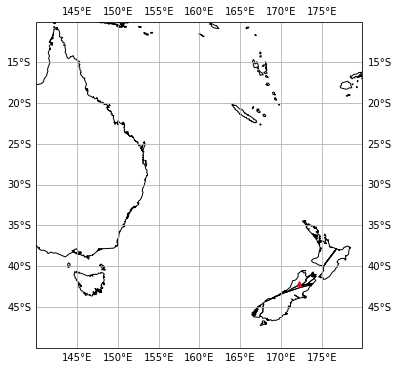

Eocene (56.0, 33.9)


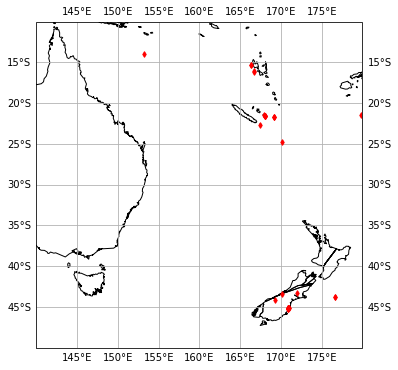

Jurassic (201.3, 145.0)


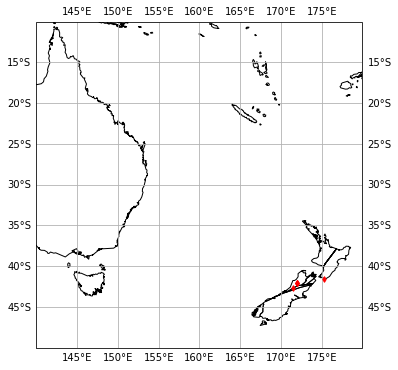

Miocene (23.03, 5.332999999999999)


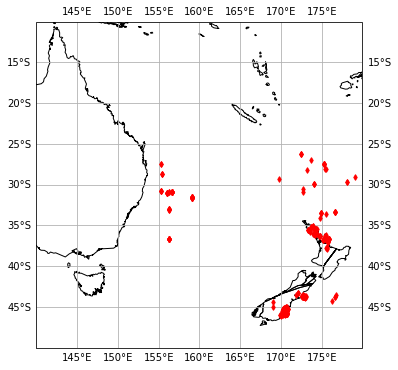

Oligocene (33.9, 23.03)


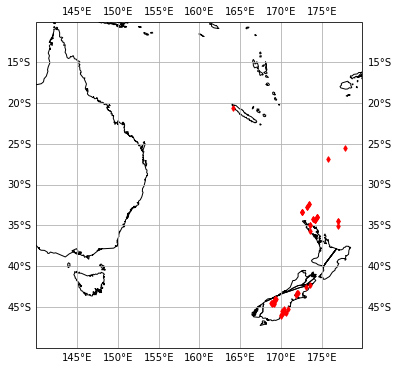

Paleocene (66.0, 56.0)


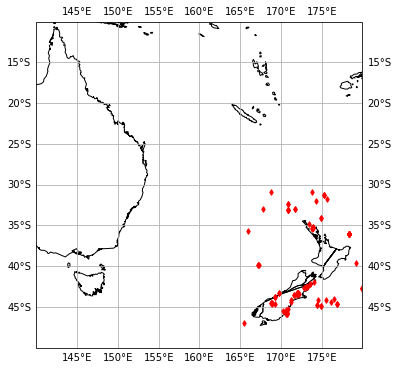

Permian (298.9, 251.90200000000002)


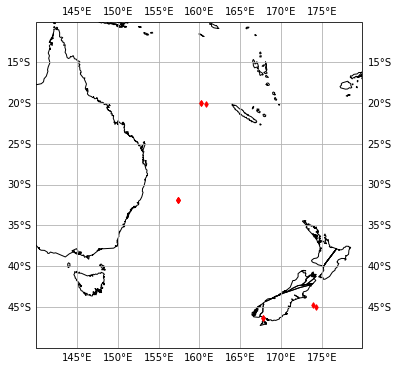

Pliocene (5.332999999999999, 2.58)


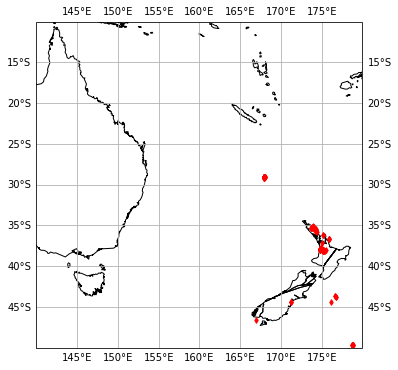

Precambrian (4600.0, 541.0)


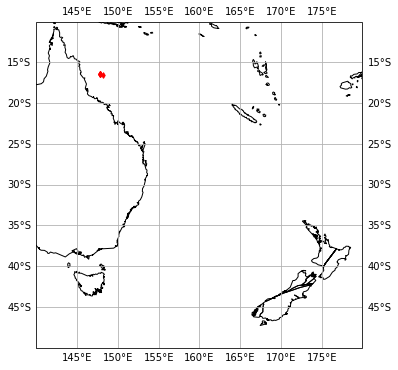

Quaternary (2.58, 0.0)


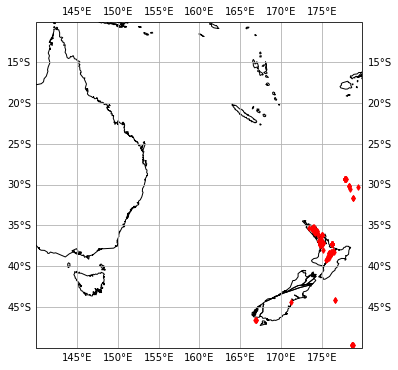

Triassic (251.90200000000002, 201.3)


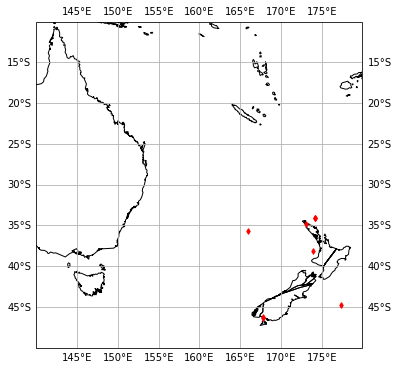

In [14]:
#Some insight into when deposits are layed down by geological age

#The grids only go to 250Ma, so anything older than that will have some missing info.
plt.hist(df['Age'])
plt.show()

print("There is clearly a bias of data toward younger times.")
print("This will have implications for how we analyse the data and try to find correlations.")

#Note: The plots are not sorted by age.
groups=df.groupby(by=["Age_Max"])
print(groups.groups.keys())

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader

# import shapefile using cartopy io
shp = shpreader.Reader('coastline.shp')
shp_geom = shp.geometries()
ft_coastline = cfeature.ShapelyFeature(shp_geom, ccrs.PlateCarree(), facecolor='none', edgecolor='k')

#agekeys = [ts.text2age(name)[1] for name, group in groups]

##### groups = df.groupby(by=["Age_Max"])
for name, group in groups:
    print(name,ts.text2age(name))
    ts.text2age(name)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([140,180, -50,-10], crs=ccrs.PlateCarree())
    
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.plot(group["Longitude"], group["Latitude"], color='r', marker="d", linestyle="", label=name)
    #plt.xlim(140,180)
    #plt.ylim(-50,-10)
    ax.add_feature(ft_coastline)
    plt.show()

## Set some functions for reading grids

In [26]:
def read_netcdf_grid(filename, return_grids=False, resample=None):
    """
    Read in a netCDF file and re-align from -180 to 180 degrees
    
    Parameters
    ----------
    filename : str
        path to netCDF file
    return_grids : bool
        optionally return lon, lat arrays associated with grid
    resample : tuple
        optionally resample grid, pass spacing in X and Y direction as a tuple
        e.g. resample=(spacingX, spacingY)
    """
    import netCDF4
    from scipy.interpolate import RegularGridInterpolator
    
    # open netCDF file and re-align from -180, 180 degrees
    with netCDF4.Dataset(filename, 'r') as cdf:
        cdf_grid = cdf["z"]
        try:
            cdf_lon = cdf['lon'][:]
            cdf_lat = cdf['lat'][:]
        except:
            cdf_lon = cdf['x'][:]
            cdf_lat = cdf['y'][:]
            
        cdf_lon_mask = cdf_lon[:] > 180
        
        if cdf_lon_mask.any():
            cdf_grid_z = np.hstack([cdf_grid[:,cdf_lon_mask], cdf_grid[:,~cdf_lon_mask]])
            cdf_lon = np.hstack([cdf_lon[cdf_lon_mask], cdf_lon[~cdf_lon_mask]])
        else:
            cdf_grid_z = cdf_grid[:]

    # resample
    if resample is not None:
        spacingX, spacingY = resample
        lon_grid = np.arange(cdf_lon.min(), cdf_lon.max()+spacingX, spacingX)
        lat_grid = np.arange(cdf_lat.min(), cdf_lat.max()+spacingY, spacingY)
        lonq, latq = np.meshgrid(lon_grid, lat_grid)
        interp = RegularGridInterpolator((cdf_lat, cdf_lon), cdf_grid_z, method='nearest', bounds_error=False)
        cdf_grid_z = interp((latq, lonq))
        cdf_lon = lon_grid
        cdf_lat = lat_grid
            
    if return_grids:
        return cdf_grid_z, cdf_lon, cdf_lat
    else:
        return cdf_grid_z
    
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def sample_grid(lon, lat, grid, extent):
    from scipy import interpolate
    
    rgi = interpolate.RegularGridInterpolator((np.linspace(extent[2], extent[3], grid.shape[0]),
                                               np.linspace(extent[0], extent[1], grid.shape[1])),
                                               grid,'nearest')
    #Modified from original, only returning 1 value
    gridval=rgi(np.c_[lat, lon])
    return(gridval[0])

## Drop any points that don't have enough data we need (i.e. ages and locations)

In [16]:
df = df[df['Latitude'].notna()]
df = df[df['Longitude'].notna()]
df = df[df['Age'].notna()]

## Perform plate reconstructions on each point

In [17]:
#Get points, assign plate ids, rotate, return reconstucted point locations.
input_directory = "../Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"
static_polygons_filename = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

In [18]:
#Assign PlateIDs to all the petlab points based on the present day static polygons they are in.
point_features=[]
for row in df.itertuples():
    #print(row.Latitude, row.Longitude,row.Age)
    point=pygplates.PointOnSphere(row.Latitude, row.Longitude)
    # Create an unclassified feature.
    # Set the feature's geometry to the input point.
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    point_feature.set_valid_time(np.ceil(row.Age),0)
    point_features.append(point_feature)   


In [19]:
# Use the static polygons to assign plate IDs and valid time periods.
# Each point feature is partitioned into one of the static polygons and assigned its
# reconstruction plate ID and valid time period.
assigned_point_features = pygplates.partition_into_plates(
    static_polygons_filename,
    rotation_model,
    point_features,
    properties_to_copy = [
        pygplates.PartitionProperty.reconstruction_plate_id,
        ])


In [20]:
rockgrid=[]
#Reconstruct each point based on ID and Age
for idx,i in enumerate(assigned_point_features):
    plateid = i.get_reconstruction_plate_id()
    recontime =i.get_valid_time()
    #print(plateid,recontime[0])
    point_to_rotate=i.get_geometry()
    #finite_rotation = rotation_model.get_rotation(to_time=recontime, moving_plate_id=plateid,from_time=0)
    stage_rotation = rotation_model.get_rotation(recontime[0], plateid, fixed_plate_id=0)
    birthPosition = stage_rotation * point_to_rotate
    point = birthPosition.to_lat_lon_array()
    rockgrid.append([point[0,1],point[0,0],recontime[0],plateid])   
    
rockgrid=np.array([np.array(xi) for xi in rockgrid])

In [21]:
#Put the results back in the dataframe
df['ReconLon'] = rockgrid[:,0]
df['ReconLat'] = rockgrid[:,1]
df['ReconAge'] = rockgrid[:,2]
df['ReconPlateID'] = rockgrid[:,3]

In [22]:
df

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,Pb206_204i_calc,Pb207_204i_calc,Pb208_204i_calc,Petlab notes,Age_Num,Age,ReconLon,ReconLat,ReconAge,ReconPlateID
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,NaN,NaN,NaN,NaN,2.58,0.0000,177.937800,-29.257800,0.0,839.0
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,NaN,NaN,NaN,NaN,2.58,0.0360,167.174994,-46.714965,1.0,81315.0
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0400,179.033010,-31.237992,1.0,839.0
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,2.58,0.0530,176.269419,-37.569659,1.0,8065.0
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,2.58,0.0555,176.269419,-37.569659,1.0,8065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,239784,GNS P (P),85736,Horomaka,Dredge,ECOSAT2-6,1500,1500,IN2016T01-DR6A,2016-07-06 00:00:00,...,NaN,NaN,NaN,NaN,145.00,5.0000,159.732763,-22.348980,5.0,869.0
990,212416,GNS P (P),82240,Horomaka,Dredge,SS2012v6-18,NaN,NaN,SS2012v6 DR18Bii,41230,...,NaN,NaN,NaN,NaN,298.90,58.0000,156.056486,-40.751994,58.0,869.0
991,60026,GNS P (P),44143,Horomaka,Surface,NaN,NaN,NaN,WI-1B,1983-11-01 00:00:00,...,NaN,NaN,NaN,NaN,145.00,60.0000,174.586122,-51.033195,60.0,8065.0
992,52516,GNS P (P),50288,Horomaka,Surface,NaN,NaN,NaN,320388,1988-03-17 00:00:00,...,NaN,NaN,NaN,NaN,145.00,60.0000,176.336076,-51.217357,60.0,8065.0


In [23]:
#Interrogate each grid to find the corresponding values for each of the samples

#Group the samples by age (i.e by grid file) for efficency (so we only open each file once per time period)
groups=df.groupby("ReconAge")
#print(groups.groups.keys())

In [24]:
#Set the file names of each of the grids
agegrid_filename = "../Data/M2020_AgeGrids/Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"
carcrust_filename = "../Data/Crust/carbon_crust_grid_{:.0f}.nc"
subcarcrust_filename = "../Data/Crust/subducted_carbon_crust_{:.0f}.nc"
carlith_filename = "../Data/Lithosphere/carbon_lithosphere_grid_{:.0f}.nc"
subcarlith_filename = "../Data/Lithosphere/subducted_carbon_lithosphere_{:.0f}.nc"
carsed_filename = "../Data/Sediment/carbon_sediment_grid_{:.0f}.nc"
subcarsed_filename ="../Data/Sediment/subducted_carbon_sediment_{:.0f}.nc"
carserp_filename = "../Data/Serpentinite/carbon_serpentinite_grid_{:.0f}.nc"
subcarserp_filename = "../Data/Serpentinite/subducted_carbon_serpentinite_{:.0f}.nc"

slabtop_filename = "../Data/slab_tops.nc" #Think about how this gets coregistered to each point's birth position
slabage_filename = "../Data/cumulative_slab_age_grid.nc" 
slabdip_filename = "../Data/cumulative_slab_dip_grid.nc"
slabthick_filename = "../Data/cumulative_slab_thickness_grid.nc"
slabvel_filename = "../Data/cumulative_slab_vel_grid.nc"
slabsubage_filename = "../Data/cumulative_subduction_age.nc"

extent_globe = [-180, 180, -90, 90]

In [27]:
#Now co-register/sample the netcdf grids with the petlab points at their correpsonding birth ages

##ASSUMPTION
#The first set of grids are "cumultive" snapshots, so they are at present day. 
#When a point is rotated to its birth location it should be over the "correct" amoun of cumultive data.
slabtop_grid = read_netcdf_grid(slabtop_filename)
slabtop_grid_filled = fill_ndimage(slabtop_grid)

slabage_grid = read_netcdf_grid(slabage_filename)
slabage_grid_filled = fill_ndimage(slabage_grid)

slabdip_grid = read_netcdf_grid(slabdip_filename)
slabdip_grid_filled = fill_ndimage(slabdip_grid)

slabthick_grid = read_netcdf_grid(slabthick_filename)
slabthick_grid_filled = fill_ndimage(slabthick_grid)

slabvel_grid = read_netcdf_grid(slabvel_filename)
slabvel_grid_filled = fill_ndimage(slabvel_grid)

slabsubage_grid = read_netcdf_grid(slabsubage_filename)
slabsubage_grid_filled = fill_ndimage(slabsubage_grid)
   
#For the time-dependent grids, loop through each one as needed.
dfs=[]
for name, grp in groups:
    print(name)
    
    #Grids only exist up to 250Ma
    if (name < 251):
        age_grid = read_netcdf_grid(agegrid_filename.format(name))
        age_grid_filled = fill_ndimage(age_grid)

        crust_grid = read_netcdf_grid(carcrust_filename.format(name))
        crust_grid_filled = fill_ndimage(crust_grid)

        subcrust_grid = read_netcdf_grid(subcarcrust_filename.format(name))
        subcrust_grid_filled = fill_ndimage(subcrust_grid)

        lith_grid = read_netcdf_grid(carlith_filename.format(name))
        lith_grid_filled = fill_ndimage(lith_grid)

        sublith_grid = read_netcdf_grid(subcarlith_filename.format(name))
        sublith_grid_filled = fill_ndimage(sublith_grid)

        sed_grid = read_netcdf_grid(carsed_filename.format(name))
        sed_grid_filled = fill_ndimage(sed_grid)

        subsed_grid = read_netcdf_grid(subcarsed_filename.format(name))
        subsed_grid_filled = fill_ndimage(subsed_grid)

        serp_grid = read_netcdf_grid(carserp_filename.format(name))
        serp_grid_filled = fill_ndimage(serp_grid)

        subserp_grid = read_netcdf_grid(subcarserp_filename.format(name))
        subserp_grid_filled = fill_ndimage(subserp_grid)
        
######
    
        #Apply the grid sampling for every point in each "age grouping"
        grp['gridage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],age_grid_filled,extent_globe),axis=1)
        grp['gridcrust'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],crust_grid_filled,extent_globe),axis=1)
        grp['gridsubcrust'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subcrust_grid_filled,extent_globe),axis=1)
        grp['gridlith'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],lith_grid_filled,extent_globe),axis=1)
        grp['gridsublith'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],sublith_grid_filled,extent_globe),axis=1)
        grp['gridsed'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],sed_grid_filled,extent_globe),axis=1)
        grp['gridsubsed'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subsed_grid_filled,extent_globe),axis=1)
        grp['gridserp'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],serp_grid_filled,extent_globe),axis=1)
        grp['gridsubserp'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subserp_grid_filled,extent_globe),axis=1)
####     grp['gridslabtop'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabtop_grid_filled,extent_globe),axis=1)
        grp['gridslabage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabage_grid_filled,extent_globe),axis=1)
        grp['gridslabdip'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabdip_grid_filled,extent_globe),axis=1)
        grp['gridslabthick'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabthick_grid_filled,extent_globe),axis=1)
        grp['gridslabvel'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabvel_grid_filled,extent_globe),axis=1)
        grp['gridslabsubage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabsubage_grid_filled,extent_globe),axis=1)

        
    else:
        grp['gridage'] = np.nan
        grp['gridcrust'] = np.nan
        grp['gridsubcrust'] = np.nan
        grp['gridlith'] = np.nan
        grp['gridsublith'] = np.nan
        grp['gridsed'] = np.nan
        grp['gridsubsed'] = np.nan
        grp['gridserp'] = np.nan
        grp['gridsubserp'] = np.nan
        grp['gridslabtop'] = np.nan
        grp['gridslabage'] = np.nan
        grp['gridslabdip'] = np.nan
        grp['gridslabthick'] = np.nan
        grp['gridslabvel'] = np.nan
        grp['gridslabsubage'] = np.nan

    
    #Add each group back to a list
    dfs.append(grp)
    
#Combine/merge all the groups back together
df1 = pd.concat(dfs, axis=0)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
44.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
55.0
57.0
58.0
59.0
60.0
64.0
65.0
67.0
68.0
69.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
108.0
109.0
110.0
111.0
113.0
114.0
115.0
117.0
119.0
123.0
125.0
127.0
128.0
142.0
145.0
151.0
161.0
170.0
173.0
190.0
196.0
241.0
259.0
260.0
270.0
285.0
324.0
356.0
381.0


In [28]:
df1

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,gridsed,gridsubsed,gridserp,gridsubserp,gridslabage,gridslabdip,gridslabthick,gridslabvel,gridslabsubage,gridslabtop
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,0.000046,0.000000,0.0,0.000000,0.00000,0.00000,0.000,0.000000,26.414402,NaN
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,0.000006,0.000039,0.0,0.000718,32.78672,22.01977,225093.375,0.000875,26.285441,NaN
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,0.000046,0.000005,0.0,0.000003,0.00000,0.00000,0.000,0.000000,25.345132,NaN
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,0.000129,0.000072,0.0,0.000003,0.00000,0.00000,0.000,0.000000,39.000000,NaN
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,0.000129,0.000072,0.0,0.000003,0.00000,0.00000,0.000,0.000000,39.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,109562,other,87-144A,Continent basement,Dredge,Sonne 36-57,2400,2700,unknown,1994-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
977,64286,GNS P (P),73035,Continent basement,Drillcore,ODP-824C,411.92,NaN,"133-824C-18R-1,42-45",32973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,44824,GNS P (P),57235,Austral,Drillcore,Pakaha-1,3360,3363,Pakaha,28126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
980,44823,GNS P (P),57234,Austral,Drillcore,Parara-1,3799,3802,Parara,27760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df1.to_csv("reconpoints.csv",columns=["Latitude","Longitude","ReconAge","ReconPlateID"])

In [30]:
df1.to_csv("petlab_withgrids.csv",index=False)

## Generate a set of randomised points to use a baseline measure for eruption events
These should accurately represent the background carbon grids, and hopefully correspond to when no eruption is triggered. Compared with an actual eruption event that should only occur when certain geological conditions are met as certain combinations/amounts of carbon subduct.

From an ML persepective the the "positive" and "negative" datasets should be balanced.

In [34]:
dfnon = df.copy()
#dfnon['Age'] = np.random.randint(0,250, size=len(dfnon))

dfnon['Latitude'] = np.random.uniform(np.min(df.Latitude),np.max(df.Latitude),size=len(dfnon))
dfnon['Longitude'] = np.random.uniform(np.min(df.Longitude),np.max(df.Longitude),size=len(dfnon))

In [35]:
#Same again, but for the "random eruptions" we can use a baseline for ml predictions
#These grids should represent a random sampling of the grids, and hopefully not correlate with co2.

#Assign PlateIDs to all the petlab points based on the present day static polygons they are in.
point_features=[]
for row in dfnon.itertuples():
    #print(row.Latitude, row.Longitude,row.Age)
    point=pygplates.PointOnSphere(row.Latitude, row.Longitude)
    # Create an unclassified feature.
    # Set the feature's geometry to the input point.
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    point_feature.set_valid_time(np.ceil(row.Age),0)
    point_features.append(point_feature)   

    
# Use the static polygons to assign plate IDs and valid time periods.
# Each point feature is partitioned into one of the static polygons and assigned its
# reconstruction plate ID and valid time period.
assigned_point_features = pygplates.partition_into_plates(
    static_polygons_filename,
    rotation_model,
    point_features,
    properties_to_copy = [
        pygplates.PartitionProperty.reconstruction_plate_id,
        ])

rockgrid=[]
#Reconstruct each point based on ID and Age
for idx,i in enumerate(assigned_point_features):
    plateid = i.get_reconstruction_plate_id()
    recontime =i.get_valid_time()
    #print(plateid,recontime[0])
    point_to_rotate=i.get_geometry()
    #finite_rotation = rotation_model.get_rotation(to_time=recontime, moving_plate_id=plateid,from_time=0)
    stage_rotation = rotation_model.get_rotation(recontime[0], plateid, fixed_plate_id=0)
    birthPosition = stage_rotation * point_to_rotate
    point = birthPosition.to_lat_lon_array()
    rockgrid.append([point[0,1],point[0,0],recontime[0],plateid])   
    
rockgrid=np.array([np.array(xi) for xi in rockgrid])

#Put the results back in the dataframe
dfnon['ReconLon'] = rockgrid[:,0]
dfnon['ReconLat'] = rockgrid[:,1]
dfnon['ReconAge'] = rockgrid[:,2]
dfnon['ReconPlateID'] = rockgrid[:,3]

In [36]:
#Same again for non-eruptions
#Interrogate each grid to find the corresponding values for each of the samples

#Group the samples by age (i.e by grid file) for efficency
groups=dfnon.groupby("ReconAge")

#Now co-register/sample the netcdf grids with the petlab points at their correpsonding birth ages
slabtop_grid = read_netcdf_grid(slabtop_filename)
slabtop_grid_filled = fill_ndimage(slabtop_grid)

slabage_grid = read_netcdf_grid(slabage_filename)
slabage_grid_filled = fill_ndimage(slabage_grid)

slabdip_grid = read_netcdf_grid(slabdip_filename)
slabdip_grid_filled = fill_ndimage(slabdip_grid)

slabthick_grid = read_netcdf_grid(slabthick_filename)
slabthick_grid_filled = fill_ndimage(slabthick_grid)

slabvel_grid = read_netcdf_grid(slabvel_filename)
slabvel_grid_filled = fill_ndimage(slabvel_grid)

slabsubage_grid = read_netcdf_grid(slabsubage_filename)
slabsubage_grid_filled = fill_ndimage(slabsubage_grid)

dfs=[]
for name, grp in groups:
    print(name)
    
    #Grids only exist up to 250Ma
    if (name < 251):
        age_grid = read_netcdf_grid(agegrid_filename.format(name))
        age_grid_filled = fill_ndimage(age_grid)

        crust_grid = read_netcdf_grid(carcrust_filename.format(name))
        crust_grid_filled = fill_ndimage(crust_grid)

        subcrust_grid = read_netcdf_grid(subcarcrust_filename.format(name))
        subcrust_grid_filled = fill_ndimage(subcrust_grid)

        lith_grid = read_netcdf_grid(carlith_filename.format(name))
        lith_grid_filled = fill_ndimage(lith_grid)

        sublith_grid = read_netcdf_grid(subcarlith_filename.format(name))
        sublith_grid_filled = fill_ndimage(sublith_grid)

        sed_grid = read_netcdf_grid(carsed_filename.format(name))
        sed_grid_filled = fill_ndimage(sed_grid)

        subsed_grid = read_netcdf_grid(subcarsed_filename.format(name))
        subsed_grid_filled = fill_ndimage(subsed_grid)

        serp_grid = read_netcdf_grid(carserp_filename.format(name))
        serp_grid_filled = fill_ndimage(serp_grid)

        subserp_grid = read_netcdf_grid(subcarserp_filename.format(name))
        subserp_grid_filled = fill_ndimage(subserp_grid)
        
#         slab_grid = read_netcdf_grid(slab_filename.format(name))
#         slab_grid_filled = fill_ndimage(slab_grid)
    
        #Apply the grid sampling for every point in each "age grouping"
        grp['gridage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],age_grid_filled,extent_globe),axis=1)
        grp['gridcrust'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],crust_grid_filled,extent_globe),axis=1)
        grp['gridsubcrust'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subcrust_grid_filled,extent_globe),axis=1)
        grp['gridlith'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],lith_grid_filled,extent_globe),axis=1)
        grp['gridsublith'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],sublith_grid_filled,extent_globe),axis=1)
        grp['gridsed'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],sed_grid_filled,extent_globe),axis=1)
        grp['gridsubsed'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subsed_grid_filled,extent_globe),axis=1)
        grp['gridserp'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],serp_grid_filled,extent_globe),axis=1)
        grp['gridsubserp'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subserp_grid_filled,extent_globe),axis=1)
#         grp['gridslab'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slab_grid_filled,extent_globe),axis=1)
        grp['gridslabtop'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabtop_grid_filled,extent_globe),axis=1)
        grp['gridslabage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabage_grid_filled,extent_globe),axis=1)
        grp['gridslabdip'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabdip_grid_filled,extent_globe),axis=1)
        grp['gridslabthick'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabthick_grid_filled,extent_globe),axis=1)
        grp['gridslabvel'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabvel_grid_filled,extent_globe),axis=1)
        grp['gridslabsubage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slabsubage_grid_filled,extent_globe),axis=1)

        
    else:
        grp['gridage'] = np.nan
        grp['gridcrust'] = np.nan
        grp['gridsubcrust'] = np.nan
        grp['gridlith'] = np.nan
        grp['gridsublith'] = np.nan
        grp['gridsed'] = np.nan
        grp['gridsubsed'] = np.nan
        grp['gridserp'] = np.nan
        grp['gridsubserp'] = np.nan
        grp['gridslabtop'] = np.nan
        grp['gridslabage'] = np.nan
        grp['gridslabdip'] = np.nan
        grp['gridslabthick'] = np.nan
        grp['gridslabvel'] = np.nan
        grp['gridslabsubage'] = np.nan
        
    
    #Add each group back to a list
    dfs.append(grp)
    
#Combine/merge all the groups back together
df2 = pd.concat(dfs, axis=0)

df2.to_csv("petlab_withgrids_neg_loc.csv",index=False)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
44.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
55.0
57.0
58.0
59.0
60.0
64.0
65.0
67.0
68.0
69.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
108.0
109.0
110.0
111.0
113.0
114.0
115.0
117.0
119.0
123.0
125.0
127.0
128.0
142.0
145.0
151.0
161.0
170.0
173.0
190.0
196.0
241.0
259.0
260.0
270.0
285.0
324.0
356.0
381.0
